# Multiome Quickstart

This notebook shows how to cross-validate a baseline model and create a submission for the Multiome part of the *Multimodal Single-Cell Integration* competition without running out of memory.

It does not show the EDA - see the separate notebook [MSCI EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/ambrosm/msci-eda-which-makes-sense).

The baseline model for the other part of the competition (CITEseq) is [here](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart).

In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

DATA_DIR = "/home/mks/PycharmProjects/multimodal_single_cell_integration/dataset"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [2]:
# If you see a warning "Failed to establish a new connection" running this cell,
# go to "Settings" on the right hand side, 
# and turn on internet. Note, you need to be phone verified.
# We need this library to read HDF files.
!pip install --quiet tables

# Loading the common metadata table

The current version of the model is so primitive that it doesn't use the metadata, but we load it anyway.

In [3]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

((119651, 5), (161877, 5))

# The scoring function

This competition has a special metric: For every row, it computes the Pearson correlation between y_true and y_pred, and then all these correlation coefficients are averaged.

In [4]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)


# Preprocessing and cross-validation

The Multiome dataset is way too large to fit into 16 GByte RAM:
- train inputs:  105942 * 228942 float32 values (97 GByte)
- train targets: 105942 *  23418 float32 values (10 GByte)
- test inputs:    55935 * 228942 float32 values (13 GByte)

To get a result with only 16 GByte RAM, we simplify the problem as follows:
- We ignore the complete metadata (donors, days, cell types).
- We read only 6000 rows of the training data.
- We drop all feature columns which are constant.
- Of the remaining columns, we keep only 4000.
- We do a PCA and keep only the 4 most important components.
- We fit a ridge regression model with 6000\*4 inputs and 6000\*23418 targets.

(6000, 228942)
(6000, 213532)
(6000, 4000)


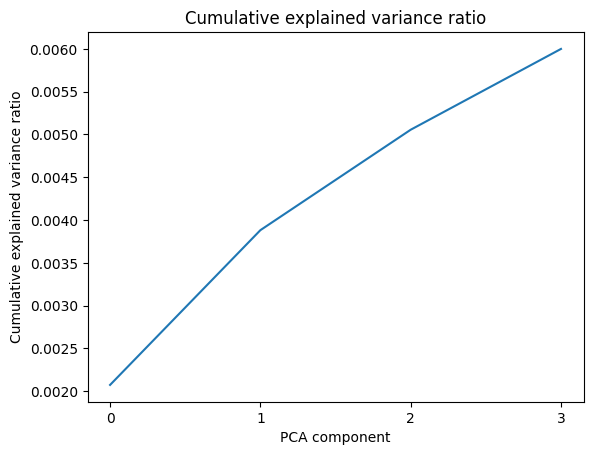

(6000, 4)
(6000, 23418)


In [5]:
#%%time
# Preprocessing

class PreprocessMultiome(BaseEstimator, TransformerMixin):
    columns_to_use = slice(10000, 14000)
    
    @staticmethod
    def take_column_subset(X):
        return X[:,PreprocessMultiome.columns_to_use]
    
    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessMultiome.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessMultiome.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=4, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

preprocessor = PreprocessMultiome()

multi_train_x = None
start, stop = 0, 6000
multi_train_x = preprocessor.fit_transform(pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS, start=start, stop=stop).values)

multi_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=start, stop=stop)
y_columns = multi_train_y.columns
multi_train_y = multi_train_y.values
print(multi_train_y.shape)

In [6]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(multi_train_x)):
    model = None
    gc.collect()
    X_tr = multi_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = multi_train_y[idx_tr]
    del idx_tr

    model = Ridge(copy_X=False)
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = multi_train_x[idx_va]
    y_va = multi_train_y[idx_va]
    del idx_va
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}{multi_train_x.shape} Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")


Fold 0: mse = 1.99765, corr =  0.682
Fold 1: mse = 1.99460, corr =  0.681
Fold 2: mse = 1.99587, corr =  0.682
Fold 3: mse = 1.99645, corr =  0.682
Fold 4: mse = 1.99872, corr =  0.681
(6000, 4) Average  mse = 1.99666; corr = 0.682
CPU times: user 7.32 s, sys: 5.63 s, total: 13 s
Wall time: 4.73 s


By the way, this ridge regression is not much better than DummyRegressor, which scores `mse = 2.01718; corr = 0.679`.

# Retraining


In [7]:
# We retrain the model and then delete the training data, which is no longer needed
model, score_list, result_df = None, None, None # free the RAM occupied by the old model
gc.collect()
model = Ridge(copy_X=False) # we overwrite the training data
model.fit(multi_train_x, multi_train_y)
del multi_train_x, multi_train_y # free the RAM
_ = gc.collect()


The final submission will contain 65744180 predictions, of which the first 6812820 are CITEseq predictions and the remaining 58931360 are Multiome. 

The Multiome test predictions have 55935 rows and 23418 columns. 55935 \* 23418 = 1’309’885’830 predictions. We'll only submit 4.5 % of these predictions. According to the data description, this subset was created by sampling 30 % of the Multiome rows, and for each row, 15 % of the columns (i.e., 16780 rows and 3512 columns per row). Consequently, when reading the test data, we can immediately drop 70 % of the rows and keep only the remaining 16780.

The eval_ids table specifies which predictions are required for the submission file.

In [8]:
%%time
# Read the table of rows and columns required for submission
eval_ids = pd.read_csv(FP_EVALUATION_IDS, index_col='row_id')

# Convert the string columns to more efficient categorical types
#eval_ids.cell_id = eval_ids.cell_id.apply(lambda s: int(s, base=16))
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())
display(eval_ids)

# Create the set of needed cell_ids
cell_id_set = set(eval_ids.cell_id)

# Convert the string gene_ids to a more efficient categorical dtype
y_columns = pd.CategoricalIndex(y_columns, dtype=eval_ids.gene_id.dtype, name='gene_id')


,cell_id,gene_id
row_id,,
0,c2150f55becb,CD86
1,c2150f55becb,CD274
2,c2150f55becb,CD270
3,c2150f55becb,CD155
4,c2150f55becb,CD112
...,...,...
65744175,2c53aa67933d,ENSG00000134419
65744176,2c53aa67933d,ENSG00000186862
65744177,2c53aa67933d,ENSG00000170959


CPU times: user 23.5 s, sys: 3.12 s, total: 26.6 s
Wall time: 26.6 s


In [9]:
# Prepare an empty series which will be filled with predictions
submission = pd.Series(name='target',
                       index=pd.MultiIndex.from_frame(eval_ids), 
                       dtype=np.float32)
submission

cell_id       gene_id        
c2150f55becb  CD86              NaN
              CD274             NaN
              CD270             NaN
              CD155             NaN
              CD112             NaN
                                 ..
2c53aa67933d  ENSG00000134419   NaN
              ENSG00000186862   NaN
              ENSG00000170959   NaN
              ENSG00000107874   NaN
              ENSG00000166012   NaN
Name: target, Length: 65744180, dtype: float32

We now compute the predictions in chunks of 5000 rows and match them with the eval_ids table row by row. The matching is very slow, but space-efficient.

In [10]:
# %%time
# Process the test data in chunks of 5000 rows

start = 0
chunksize = 5000
total_rows = 0
while True:
    multi_test_x = None # Free the memory if necessary
    gc.collect()
    # Read the 5000 rows and select the 30 % subset which is needed for the submission
    multi_test_x = pd.read_hdf(FP_MULTIOME_TEST_INPUTS, start=start, stop=start+chunksize)
    rows_read = len(multi_test_x)
    needed_row_mask = multi_test_x.index.isin(cell_id_set)
    multi_test_x = multi_test_x.loc[needed_row_mask]
    
    # Keep the index (the cell_ids) for later
    multi_test_index = multi_test_x.index
    
    # Predict
    multi_test_x = multi_test_x.values
    multi_test_x = preprocessor.transform(multi_test_x)
    test_pred = model.predict(multi_test_x)
    
    # Convert the predictions to a dataframe so that they can be matched with eval_ids
    test_pred = pd.DataFrame(test_pred,
                             index=pd.CategoricalIndex(multi_test_index,
                                                       dtype=eval_ids.cell_id.dtype,
                                                       name='cell_id'),
                             columns=y_columns)
    gc.collect()
    
    # Fill the predictions into the submission series row by row
    for i, (index, row) in enumerate(test_pred.iterrows()):
        row = row.reindex(eval_ids.gene_id[eval_ids.cell_id == index])
        submission.loc[index] = row.values
    print('na:', submission.isna().sum())

    #test_pred_list.append(test_pred)
    total_rows += len(multi_test_x)
    print(total_rows)
    if rows_read < chunksize: break # this was the last chunk
    start += chunksize
    
del multi_test_x, multi_test_index, needed_row_mask


(1533, 228942)
(1533, 213532)
(1533, 4000)
(1533, 4)
na: 60360284
1533
(1486, 228942)
(1486, 213532)
(1486, 4000)
(1486, 4)
na: 55141452
3019
(1517, 228942)
(1517, 213532)
(1517, 4000)
(1517, 4)
na: 49813748
4536
(1528, 228942)
(1528, 213532)
(1528, 4000)
(1528, 4)
na: 44447412
6064
(1492, 228942)
(1492, 213532)
(1492, 4000)
(1492, 4)
na: 39207508
7556
(1506, 228942)
(1506, 213532)
(1506, 4000)
(1506, 4)
na: 33918436
9062
(1490, 228942)
(1490, 213532)
(1490, 4000)
(1490, 4)
na: 28685556
10552
(1492, 228942)
(1492, 213532)
(1492, 4000)
(1492, 4)
na: 23445652
12044
(1475, 228942)
(1475, 213532)
(1475, 4000)
(1475, 4)
na: 18265452
13519
(1473, 228942)
(1473, 213532)
(1473, 4000)
(1473, 4)
na: 13092276
14992
(1499, 228942)
(1499, 213532)
(1499, 4000)
(1499, 4)
na: 7827788
16491
(289, 228942)
(289, 213532)
(289, 4000)
(289, 4)
na: 6812820
16780


# Submission

As we don't yet have the CITEseq predictions, we save the partial predictions so that they can be used in the [CITEseq notebook](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart).

In [11]:
submission.reset_index(drop=True, inplace=True)
submission.index.name = 'row_id'
with open("partial_submission_multi.pickle", 'wb') as f: pickle.dump(submission, f)
submission

row_id
0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
              ...   
65744175    7.271666
65744176    0.017597
65744177    0.025040
65744178    1.933744
65744179    5.111444
Name: target, Length: 65744180, dtype: float32